In [9]:
def a1(b):
    b[0]=1.2
    
def a2(b):
    b[0]=1.5

In [1]:
import torch
import torch.nn as nn

In [10]:
c = [0,1,2]
print(c)

a1(c)
print(c)


a2(b=c)
print(c)


[0, 1, 2]
[1.2, 1, 2]
[1.5, 1, 2]


In [11]:
isinstance('s', str)

True

In [15]:
a =  torch.randn(4,256)
b =  torch.randn(2,256)

In [20]:
print(a.norm(2))
print(b.norm(2))

a_norm = a/a.norm(2)
b_norm = b/b.norm(2)

print(a_norm.norm(2))
print(b_norm.norm(2))


a_norm.matmul(b_norm.T).mean()

tensor(32.9661)
tensor(22.9427)
tensor(1.0000)
tensor(1.0000)


tensor(-0.0058)

In [1]:
from pytorch_lightning import LightningModule

In [2]:
from Light.model import SpeakerModule
from hyperpyyaml import load_hyperpyyaml
from Light.dataset import SubDatasets, SubLoaders
import time

In [24]:
config_yaml = '../TrainAndTest/Fbank/ResNets/cnc1_resnet_light.yaml'
with open(config_yaml, 'r') as f:
        config_args = load_hyperpyyaml(f)

In [39]:
train_dir, valid_dir, train_extract_dir = SubDatasets(config_args)

model = SpeakerModule(config_args=config_args, train_dir=train_dir)

100%|███████████████████████████████████████████████████| 408064/408064 [00:00<00:00, 575813.85it/s]


==> There are 797 speakers in Dataset.
    There are 408064 egs in Dataset


100%|███████████████████████████████████████████████████████| 1578/1578 [00:00<00:00, 603557.52it/s]

==> There are 792 speakers in Dataset.
    There are 1578 egs in Dataset


In [28]:
model._set_hparams(config_args)

In [31]:
type(model.hparams.classifier)


Define_Model.Loss.SoftmaxLoss.AdditiveMarginLinear

In [41]:
model._set_hparams({'config_args': config_args})

In [ ]:
model.hparams

In [50]:
class CBAM(nn.Module):
    # input should be like [Batch, channel, time, frequency]
    def __init__(self, inplanes, planes, time_freq='both'):
        super(CBAM, self).__init__()
        self.time_freq = time_freq

        self.cov_t = nn.Conv2d(inplanes, planes, kernel_size=(
            7, 1), stride=1, padding=(3, 0))
        self.avg_t = nn.AdaptiveAvgPool2d((None, 1))

        self.cov_f = nn.Conv2d(inplanes, planes, kernel_size=(
            1, 7), stride=1, padding=(0, 3))
        self.avg_f = nn.AdaptiveAvgPool2d((1, None))

        self.activation = nn.Sigmoid()

    def forward(self, input):
        t_output = input.mean(dim=2, keepdim=True)
        t_output = self.cov_t(t_output)
        t_output = self.activation(t_output)
        t_output = input * t_output

        f_output = input.mean(dim=3, keepdim=True)
        f_output = self.cov_f(f_output)
        f_output = self.activation(f_output)
        f_output = input * f_output

        output = (t_output + f_output) / 2

        return output
    
class CBAM2(nn.Module):
    # input should be like [Batch, channel, time, frequency]
    def __init__(self, inplanes, planes, time_freq='both'):
        super(CBAM2, self).__init__()
        self.time_freq = time_freq

        self.cov_t = nn.Conv2d(inplanes, planes, kernel_size=(
            7, 1), stride=1, padding=(3, 0))
        self.avg_t = nn.AdaptiveAvgPool2d((None, 1))

        self.cov_f = nn.Conv2d(inplanes, planes, kernel_size=(
            1, 7), stride=1, padding=(0, 3))
        self.avg_f = nn.AdaptiveAvgPool2d((1, None))

        self.activation = nn.Sigmoid()

    def forward(self, input):
        t_output = self.avg_t(input)
        t_output = self.cov_t(t_output)
        t_output = self.activation(t_output)
        t_output = input * t_output

        f_output = self.avg_f(input)
        f_output = self.cov_f(f_output)
        f_output = self.activation(f_output)
        f_output = input * f_output

        output = (t_output + f_output) / 2

        return output
    
class CBAM3(nn.Module):
    # input should be like [Batch, channel, time, frequency]
    def __init__(self, inplanes, planes, time_freq='both'):
        super(CBAM3, self).__init__()
        self.time_freq = time_freq

        self.cov_t = nn.Conv2d(inplanes, planes, kernel_size=(
            7, 1), stride=1, padding=(3, 0))
        self.avg_t = nn.AdaptiveAvgPool2d((None, 1))

        self.cov_f = nn.Conv2d(inplanes, planes, kernel_size=(
            1, 7), stride=1, padding=(0, 3))
        self.avg_f = nn.AdaptiveAvgPool2d((1, None))

        self.activation = nn.Sigmoid()

    def forward(self, input):
        t_output = input.mean(dim=2, keepdim=True)
        t_output = self.cov_t(t_output)
        t_output = self.activation(t_output)
        print(t_output.shape)
        # t_output = input * 
        f_output = input.mean(dim=3, keepdim=True)
        f_output = self.cov_f(f_output)
        f_output = self.activation(f_output)
        print(f_output.shape)
        
        print((t_output+f_output).shape)
        
        print( ((t_output+f_output) / 2 * input) == ((t_output*input + f_output*input) / 2))
        # f_output = input * f_output
        output = (t_output+f_output) / 2 * input

        return output

In [51]:
x = torch.randn(128, 16, 200, 40)
cbam = CBAM(16, 16)
cbam2 = CBAM2(16, 16)
cbam3 = CBAM3(16, 16)

In [40]:
loops = 50
start = time.time()
for i in range(loops):
    y = cbam(x)
dur1 = time.time() -start
# print(dur)

start = time.time()
for i in range(loops):
    y = cbam2(x)
dur2 = time.time() -start

start = time.time()
for i in range(loops):
    y = cbam3(x)
dur3 = time.time() -start


start = time.time()
for i in range(loops):
    y = cbam2(x)
dur2 += time.time() -start


start = time.time()
for i in range(loops):
    y = cbam(x)
dur1 += time.time() -start

start = time.time()
for i in range(loops):
    y = cbam3(x)
dur3 += time.time() -start


print(dur1, dur2, dur3)

3.5034573078155518 3.5351667404174805 2.6490159034729004


In [78]:
a = torch.randn(10, 16, 1, 40)
b = torch.randn(10, 16, 100, 1)
c = torch.randn(10, 16, 100, 40)
# a

In [79]:
d = a*c + b*c
e = (a+b)*c

print((d - e > 1e-6).sum())

tensor(0)


In [58]:
f = (a.repeat(1,1,100,1) + b.repeat(1,1,1,40))*c

In [80]:
print((d - e > 1e-6).sum())

tensor(0)


In [114]:
class SqueezeExcitation(nn.Module):
    # input should be like [Batch, channel, time, frequency]
    def __init__(self, inplanes, reduction_ratio=4):
        super(SqueezeExcitation, self).__init__()
        self.reduction_ratio = reduction_ratio

        self.glob_avg = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(inplanes, max(
            int(inplanes / self.reduction_ratio), 1))
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(
            max(int(inplanes / self.reduction_ratio), 1), inplanes)
        self.activation = nn.Sigmoid()

    def forward(self, input):
        scale = self.glob_avg(input).squeeze(dim=2).squeeze(dim=2)
        scale = self.fc1(scale)
        scale = self.relu(scale)
        scale = self.fc2(scale)
        scale = self.activation(scale).unsqueeze(2).unsqueeze(2)

        output = input * scale

        return output

    def __repr__(self):
        return "SqueezeExcitation(reduction_ratio=%f)" % self.reduction_ratio

    
class SqueezeExcitation2(nn.Module):
    # input should be like [Batch, channel, time, frequency]
    def __init__(self, inplanes, reduction_ratio=4):
        super(SqueezeExcitation2, self).__init__()
        self.reduction_ratio = reduction_ratio

        self.glob_avg = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Conv1d(inplanes, max(
            int(inplanes / self.reduction_ratio), 1), kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv1d(
            max(int(inplanes / self.reduction_ratio), 1), inplanes, kernel_size=1)
        self.activation = nn.Sigmoid()

    def forward(self, input):
        scale = self.glob_avg(input).squeeze(dim=2)
        # print(scale)
        scale = self.fc1(scale)
        scale = self.relu(scale)
        scale = self.fc2(scale)
        scale = self.activation(scale).unsqueeze(2)

        output = input * scale

        return output

    def __repr__(self):
        return "SqueezeExcitation2(reduction_ratio=%f)" % self.reduction_ratio


In [115]:
x = torch.randn(256, 16, 200, 40)
cbam1 = SqueezeExcitation(16, 2)
cbam2 = SqueezeExcitation2(16, 2)


In [116]:
loops = 100
start = time.time()
for i in range(loops):
    y = cbam1(x)
dur1 = time.time() -start
# print(dur)

start = time.time()
for i in range(loops):
    y = cbam2(x)
dur2 = time.time() -start

start = time.time()
for i in range(loops):
    y = cbam2(x)
dur2 += time.time() -start

start = time.time()
for i in range(loops):
    y = cbam1(x)
dur1 += time.time() -start

print(dur1, dur2)
# 1.1559534072875977 1.2867701053619385

4.63132905960083 4.759135484695435


In [86]:
(cbam1(x) - cbam2(x) > 1e-6).sum()

tensor(8194653)

In [117]:
import torch.nn.functional as F


In [118]:
class Conv1dReluBn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        return self.bn(F.relu(self.conv(x)))

In [165]:
from Define_Model.model import AttrDict

In [166]:
config_args = {'a':1, 'b':2, 'c':3}
at = AttrDict(config_args)

{'a': 1, 'b': 2, 'c': 3}

In [170]:
5370624/5994

896.0

In [171]:
3068928/5994

512.0

In [ ]:
git config core.ignorecase false

In [3]:
import numpy as np

In [5]:
a = np.random.randint(-32768, 32767, 16000, dtype='int16')

In [6]:
a

array([ 17532,  -3628,  17938, ...,  10637, -16098, -15814], dtype=int16)

In [7]:
np.random.randint(10, 20) * 0.1 + 2

3.9000000000000004

In [11]:
len('\0BFM \04')

6

In [12]:
[1,2,3]*3

[1, 2, 3, 1, 2, 3, 1, 2, 3]

In [23]:
import matplotlib.pyplot as plt

(array([28., 23., 13., 14.,  9.,  5.,  4.,  1.,  1.,  2.]),
 array([  2.36588291,  15.1102407 ,  27.85459849,  40.59895628,
         53.34331407,  66.08767185,  78.83202964,  91.57638743,
        104.32074522, 117.06510301, 129.8094608 ]),
 <BarContainer object of 10 artists>)

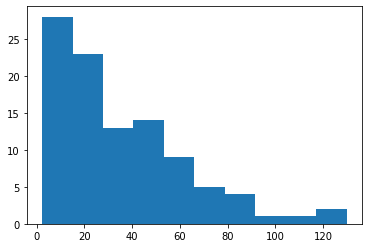

In [34]:
a = np.abs(np.random.normal(2, 50, 100) + 2)

plt.hist(a)

In [25]:
import torch

In [32]:
# early stoppint top-k
top_lossepochs = []

for i in range(1):
    top_lossepochs.append([10*float(torch.randn(1)), i])

tops = torch.tensor(top_lossepochs)
print(top_lossepochs)
print(tops)
tops_4 = tops[torch.argsort(tops[:, 0])][:4,1].long().tolist()

print(tops_4)

[[5.152730941772461, 0]]
tensor([[5.1527, 0.0000]])
[0]


In [5]:
from tqdm import tqdm
import time

In [18]:
pbar = tqdm(range(100), ncols=50)

  0%|                     | 0/100 [00:00<?, ?it/s]

In [19]:
for i in pbar:
    time.sleep(0.1)
    if i % 10 :
        pbar.set_description('iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiioiooiooiiiiiiiiiiiioioioiooooiooiiiiif: {}'.format(i))

iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiioiooiooiiiii


In [24]:
a = torch.tensor(True)
b = torch.tensor(False)

if a + b:
    print(1)

1


In [29]:
tops = torch.tensor(top_lossepochs)
tops_k = tops[torch.argsort(tops[:, 0])][:self.top_k, 1].long().tolist()

NameError: name 'self' is not defined